In [5]:
# load json from file
import json
import pickle
import random
import math
import numpy as np

def loadGame(game):
    with open('./games/'+game+'.json') as f:
        data = json.load(f)
    return data

games = [
    # loadGame('balloon'),
    # loadGame('riskavoidance'),
    loadGame('double1'),
    loadGame('tripple1'),
    # loadGame('tripple2'),
    loadGame('tripple3'),
    loadGame('tripple4'),
]



In [6]:
alpha = 0.1

class Node:
  def __init__(self, node, nodes):
    self.id = pickle.dumps(node)
    self.rewardHistory = []
    self.Vc = 0
    if 'rewards' in node:
      self.rewards = node['rewards']
    if 'actions' not in node:
      self.isLeaf = True
      return
    self.isLeaf = False
    if 'up' in node['actions']:
      self.up = getNode(node['actions']['up'][0]['next'], nodes)
    if 'down' in node['actions']:
      self.down = getNode(node['actions']['down'][0]['next'], nodes)
    if 'left' in node['actions']:
      self.left = getNode(node['actions']['left'][0]['next'], nodes)
    if 'right' in node['actions']:
      self.right = getNode(node['actions']['right'][0]['next'], nodes)

  def __str__(self):
    if self.isLeaf:
      return 'Leaf'
    return 'Node'
  
  def getReward(self):
    # get random number
    r = random.random()
    # sample reward
    s = 0
    if not hasattr(self, 'rewards'):
      return 0
    for i in range(len(self.rewards)):
      s += self.rewards[i]['p']
      if r < s:
        reward = self.rewards[i]['value']
        self.rewardHistory.append(reward)
        self.Vc = self.Vc + alpha * (reward - self.Vc)
        return reward
      
  def getAverageReward(self):
    return sum(self.rewardHistory) / len(self.rewardHistory) if len(self.rewardHistory) > 0 else 0
#    return self.Vc

def getNode(node, nodes):
  # return node in nodes with matching id
  for n in nodes:
    if n.id == pickle.dumps(node):
      return n
  node = Node(node, nodes)
  nodes.append(node)
  return node


In [25]:
import requests

# get env variable OPENAI_API_KEY
import os
api_key = os.environ.get('OPENAI_API_KEY')

url = "https://api.openai.com/v1/chat/completions"

def chat(messages):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + api_key,
    }

    data = {
        "model": "gpt-4", # gpt-3.5-turbo",
        "messages": messages,
        # "max_tokens": 4000,
        "temperature": 0.2
    }

    response = requests.post(url, headers=headers, json=data, timeout=10)

    data = response.json()

    if 'choices' not in data or len(data['choices']) == 0:
        print(data)
        return 'Error'

    return data['choices'][0]['message']


In [ ]:

messages = []
messages.append({ "role": "user", "content": "Hello" })

message = chat(messages)
print(message['content'])
messages.append(message)
messages.append({ "role": "user", "content": "What is one plus one?" })

chat(messages)


In [8]:
def getPaths(node):
    if node.isLeaf:
        return ['']
    paths = []
    for dir in ['left', 'right', 'up', 'down']:
        if hasattr(node, dir):
            subpaths = getPaths(getattr(node, dir))
            paths += [dir[0] + p for p in subpaths]
    return paths

def getPossibleDirections(game):
    nodes = []
    start = Node(game['start'], nodes)
    paths = getPaths(start)

    return paths

getPossibleDirections(games[3])


['rrddd', 'rddrd', 'rdddr', 'ddrrd', 'ddrdr', 'dddrr']

In [9]:
def followDirections(game, directions):
    nodes = []
    start = Node(game['start'], nodes)
    rewards = []
    node = start
    for direction in directions:
        if direction == 'l':
            node = node.left
        if direction == 'r':
            node = node.right
        if direction == 'u':
            node = node.up
        if direction == 'd':
            node = node.down
        rewards.append(node.getReward())

    return rewards

# directions = ['l', 'l', 'u']

# rewards = followDirections(games[0], directions)

# rewards


In [62]:
gameNum = 3
runResults = []


In [65]:
game = games[gameNum]

messages = [
  {
    "role": "system",
    "content": """"
You are about to play a game. The game consists of moving around a grid world by giving directions for a path to go. You can move up, down, left, or right.
Each time you visit a grid, you receive a reward. The reward is random, but the probability distribution is unknown.

The possible paths are therefore:
- """ + '\n- '.join(getPossibleDirections(game)) + """

No other paths are possible.

Your goal is to get an as high score as possible after 75 games. You only respond with directions and nothing else. After each turn you continue by giving directions for the next path.

Since the goal is to achieve an as high score as possible after 75 games, it is advantageous to figure out the ideal strategy. You can do this by playing the game many times and trying different strategies. Towards the end however, it makes sense to take the path that is most likely to give the highest score.

The game is played by the assistant giving directions, and the user gives the rewards.
"""
#     "content": """"
# You are about to play a game. The game consists of moving around a grid world by giving directions for a path to go. You can move up, down, left, or right.
# Each time you visit a grid, you receive a reward. The reward is random, but the probability distribution is unknown.

# The possible paths are:
# - """ + '\n- '.join(getPossibleDirections(games[0])) + """

# No other paths are possible.

# Your goal is to get an as high score as possible after 75 games. You only respond with directions and nothing else. After each turn you continue by giving directions for the next path.

# To get an as high score as possible, it is important to figure out the ideal strategy. You can do this by playing the game many times and trying different strategies. However, this is time consuming. Instead, you can use a reinforcement learning algorithm to learn the optimal strategy.

# A successful player must gather information as to which paths are the most rewarding. This is done by exploring the grid world and trying different paths. The player must also remember which paths are the most rewarding. This is done by keeping track of the rewards for each path.

# The game is played by the assistant giving directions, and the user gives the rewards.
# """
#     "content": """"
# You are an agent playing a game. In this game you move around in a grid world. You can move up, down, left, or right.

# However you cannot move freely. You can only follow a set of paths. The paths are given as a list of directions such as `l, l, u` which stands for left, left, up.

# The possible paths are:
# - """ + '\n- '.join(getPossibleDirections(games[0])) + """

# No other paths are possible.

# Each node that you visit gives you a reward. The reward is random, but the probability distribution is unknown.

# Your goal is to get an as high score as possible after 75 games. You only respond with directions and nothing else. After each turn you continue by giving directions for the next path.

# Good luck!
# """
  },
  {
    "role": "user",
    "content": "Let's start. Each turn you give me directions and I give the rewards you received at each visited node. At each turn you start at the original starting position. Give me the first set of directions."
  },
  {
    "role": "assistant",
    "content": "`d, d, r, r`"
  },
  {
    "role": "user",
    "content": "Rewards: 0, 0, 0, 0"
  },
  {
    "role": "assistant",
    "content": "`r, r, d, d`"
  },
  {
    "role": "user",
    "content": "Rewards: 0, 0, 0, 0"
  },
]

score = 0
scores = []
dirs = []


In [66]:
import time

while len(scores) < 75:
#for i in range(75):
    try:
        message = chat(messages)
    except:
        print('OpenAI borked. Waiting 1s. Then continuing.')
        # wait 1s
        time.sleep(1)
        continue
    if message == 'Error':
        print('OpenAI borked. Waiting 1s. Then continuing.')
        # wait 1s
        time.sleep(1)
        continue
    print(message['content'])
    content = message['content']
    # extract directions between back quotes
    directions = content[content.find('`')+1:content.rfind('`')].split(', ')
    print("Directions: " + str(directions))
    rewards = followDirections(game, directions)
    dirs.append(directions)
    messages.append(message)
    content = "Rewards: " + ', '.join([str(x) for x in rewards]) + ". Next?"
    messages.append({
        "role": "user",
        "content": content
    })
    print(content)
    score += sum(rewards)

    # message = chat(messages)
    # messages.append(message)

    print('Game ' + str(len(scores)) + ' done. ' + str(score))
    scores.append(score)

print('Score: ' + str(score))
runResults.append(score)

print(runResults)


`r, d, d, r`
Directions: ['r', 'd', 'd', 'r']
Rewards: 0, 1, 0, 0. Next?
Game 0 done. 1
`r, d, d, d`
Directions: ['r', 'd', 'd', 'd']
Rewards: 0, 0, 1, 0. Next?
Game 1 done. 2
`d, d, r, d`
Directions: ['d', 'd', 'r', 'd']
Rewards: 2, 0, 1, 0. Next?
Game 2 done. 5
`d, d, d, r`
Directions: ['d', 'd', 'd', 'r']
Rewards: 0, 0, 3, 0. Next?
Game 3 done. 8
`d, d, r, d`
Directions: ['d', 'd', 'r', 'd']
Rewards: 0, 0, 1, 0. Next?
Game 4 done. 9
`r, d, d, r`
Directions: ['r', 'd', 'd', 'r']
Rewards: 0, 2, 1, 0. Next?
Game 5 done. 12
`d, d, d, r`
Directions: ['d', 'd', 'd', 'r']
Rewards: 0, 1, 0, 0. Next?
Game 6 done. 13
`r, d, d, d`
Directions: ['r', 'd', 'd', 'd']
Rewards: 0, 0, 1, 0. Next?
Game 7 done. 14
`d, d, r, d`
Directions: ['d', 'd', 'r', 'd']
Rewards: 0, 1, 1, 0. Next?
Game 8 done. 16
`r, d, d, r`
Directions: ['r', 'd', 'd', 'r']
Rewards: 0, 0, 1, 0. Next?
Game 9 done. 17
`d, d, d, r`
Directions: ['d', 'd', 'd', 'r']
Rewards: 2, 0, 3, 0. Next?
Game 10 done. 22
`r, d, d, d`
Directions: 

In [55]:
# sum(runResults) / len(runResults)
runResults



[150, 150, 150]

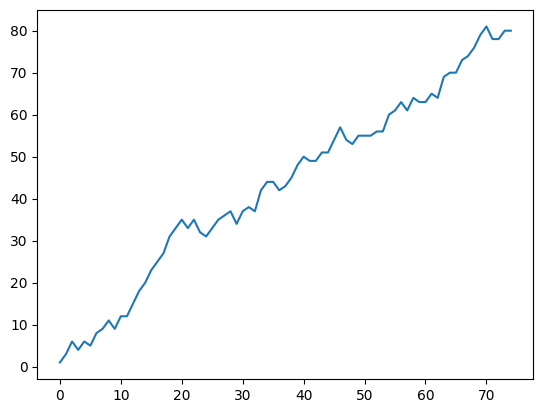

In [93]:
import matplotlib.pyplot as plt
plt.plot(scores)

In [45]:
messages

[{'role': 'system',
  'content': '"\nYou are about to play a game. The game consists of moving around a grid world by giving directions for a path to go. You can move up, down, left, or right.\nEach time you visit a grid, you receive a reward. The reward is random, but the probability distribution is unknown.\n\nThe possible paths are:\n- llu\n- ull\n- uldlu\n\nNo other paths are possible.\n\nYour goal is to get an as high score as possible after 75 games. You only respond with directions and nothing else. After each turn you continue by giving directions for the next path.\n\nTo get an as high score as possible, it is important to figure out the ideal strategy. You can do this by playing the game many times and trying different strategies. However, this is time consuming. Instead, you can use a reinforcement learning algorithm to learn the optimal strategy.\n\nThe game is played by the assistant giving directions, and the user gives the rewards.\n'},
 {'role': 'user',
  'content': "Le

In [82]:
chat(messages + [{ "role": "user", "content": "What is the ideal strategy based on the game so far?"}])['content']


"Based on the rewards received so far, the ideal strategy appears to be taking the path `u, l, l`. Although the rewards are not consistently high, this path has provided more positive rewards compared to the other paths. The other paths, `l, l, u` and `u, l, d, l, u`, often result in negative or zero rewards. To maximize the score, it's better to choose the path `u, l, l`."

In [67]:
# create set of unique dirs
# unique_dirs = []
# for dirs in dirs:
#     unique_dirs += ','.join(dirs)
# unique_dirs = set(unique_dirs)

str_dirs = [','.join(dirs) for dirs in dirs]
unique_dirs = set(str_dirs)
unique_dirs

[(dir, len([d for d in str_dirs if d == dir])) for dir in unique_dirs]


[('u,l,l', 26), ('l,l,u', 23), ('u,l,d,l,u', 26)]